#Integrantes#
*   Pablo Calle
*   Daniel Castillo
*   Jeisson Garcia
*   Valentina Ramirez


In [1]:
import pydot
from IPython.display import Image, display
import queue
import numpy as np

In [2]:
class Node ():
  def __init__(self, state,value,operators,operator=None, parent=None,objective=None):
    self.state= state
    self.value = value
    self.children = []
    self.parent=parent
    self.operator=operator
    self.objective=objective
    self.level=0
    self.operators=operators
    self.v=0

    
  def add_child(self, value, state, operator):
    node=type(self)(value=value, state=state, operator=operator,parent=self,operators=self.operators)
    node.level=node.parent.level+1
    self.children.append(node)
    return node
  
  def add_node_child(self, node):
    node.level=node.parent.level+1
    self.children.append(node)    
    return node

  #Devuelve todos los estados según los operadores aplicados
  def getchildrens(self):
    return [
        self.getState(i) 
          if not self.repeatStatePath(self.getState(i)) 
            else None for i, op in enumerate(self.operators)]
    
  def getState(self, index):
    pass
  
  def __eq__(self, other):
    return self.state == other.state
 
  def __lt__(self, other):
    return self.f() < other.f()
   
  
  def repeatStatePath(self, state):
      n=self
      while n is not None and n.state!=state:
          n=n.parent
      return n is not None
    
  def pathObjective(self):
      n=self
      result=[]
      while n is not None:
          result.append(n)
          n=n.parent
      return result
  
  def heuristic(self):
    return 0
  
  def cost(self):
    return 1
  
  def f(self): 
    return self.cost()+self.heuristic()

  ### Crear método para criterio objetivo
  ### Por defecto vamos a poner que sea igual al estado objetivo, para cada caso se puede sobreescribir la función
  def isObjective(self):
    return (self.state==self.objetive.state)

In [3]:
class Tree ():
  def __init__(self, root ,operators):
    self.root=root
    self.operators=operators

  def printPath(self,n):
    stack=n.pathObjective()
    path=stack.copy()
    while len(stack)!=0:
        node=stack.pop()
        if node.operator is not None:
            print(f'operador:  {self.operators[node.operator]} \t estado: {node.state}')
        else:
            print(f' {node.state}')
    return path

  def reinitRoot(self):
    self.root.operator=None
    self.root.parent=None
    self.root.objective=None
    self.root.children = []
    self.root.level=0

  ## Primero a lo ancho
  def breadthFirst(self,endState):
    self.reinitRoot()
    pq=queue.Queue()
    pq.put(self.root)
    while not pq.empty():
      node=pq.get()
      children=node.getchildrens()
      for i,child in enumerate(children):
        if child is not None:
          newChild=node.add_child(value=node.value+'-'+str(i), state=child, operator=i)
          pq.put(newChild)
          if endState==child:
            return newChild

  ## Primero en profundidad
  def dephFirst(self, endState):
    self.reinitRoot()
    pq=[]
    pq.append(self.root)    
    while len(pq)>0:
      node=pq.pop()
      if (node.parent is not None):
        node.parent.add_node_child(node)
      children=node.getchildrens()
      temp=[]
      for i,child in enumerate(children):
        if child is not None:
          newChild=type(self.root)(value=node.value+'-'+str(i),state=child,operator=i,parent=node, operators=node.operators)
          temp.append(newChild)
          if endState==child:
            node.add_node_child(newChild)
            return newChild
      #Adicionar los hijos en forma inversa para que salga primero el primero que se adicionó
      temp.reverse()
      for e in temp:
        pq.append(e)
  
  ## Costo uniforme
  def costUniform(self,endState):
    self.reinitRoot()
    pq=queue.PriorityQueue()
    pq.put((self.root.cost(),self.root))
    while not pq.empty():
      node=pq.get()[1]
      children=node.getchildrens()
      for i,child in enumerate(children):
        if child is not None:
          newChild=node.add_child(value=node.value+'-'+str(i), 
                                  state=child, operator=i)
          pq.put((newChild.cost(),newChild))
          if endState==child:
            return newChild

  ## Primero el mejor 
  def bestFirst(self,endState):
    self.reinitRoot()
    pq=queue.PriorityQueue()
    pq.put((self.root.heuristic(),self.root))
    while not pq.empty():
      node=pq.get()[1]
      children=node.getchildrens()
      for i,child in enumerate(children):
        if child is not None:
          newChild=node.add_child(value=node.value+'-'+str(i), 
                                  state=child, operator=i)
          pq.put((newChild.heuristic(),newChild))
          if endState==child:
            return newChild

  ## A*
  def Aasterisk(self,endState):
    self.reinitRoot()
    pq=queue.PriorityQueue()
    pq.put((self.root.f(),self.root))
    while not pq.empty():
      node=pq.get()[1]
      children=node.getchildrens()
      for i,child in enumerate(children):
        if child is not None:
          newChild=node.add_child(value=node.value+'-'+str(i), 
                                  state=child, operator=i)
          pq.put((newChild.f(),newChild))
          if endState==child:
            return newChild

    ## Generar los hijos del nodo 
    
  def AlfaBeta(self, depth):
    self.root.v=self.AlfaBetaR(self.root, depth, float('-inf'), float('inf'), True)
    ## Comparar los hijos de root
    values=[c.v for c in self.root.children]
    maxvalue=max(values)
    index=values.index(maxvalue)
    return self.root.children[index]

  def AlfaBetaR(self, node, depth, alfa, beta, maxPlayer):
    if depth==0 or node.isObjective():
      node.v=node.heuristic()
      return node.heuristic()
    ## Generar los hijos del nodo
    children=node.getchildrens()
    
    ## Según el jugador que sea en el árbol
    if maxPlayer:
      value=float('-inf')
      for i,child in enumerate(children):
        if child is not None:
          newChild=type(self.root)(value=node.value+'-'+str(i),state=child,operator=i,parent=node, 
                                   operators=node.operators,player=False)
          newChild=node.add_node_child(newChild)
          value=max(value,self.AlfaBetaR(newChild,depth-1,alfa,beta,False))
          alfa = max(alfa, value)
          if alfa >= beta:
            break
      #return value
      #node.v=value
      #return value
    else:
      value=float('inf')
      for i,child in enumerate(children):
        if child is not None:
          newChild=type(self.root)(value=node.value+'-'+str(i),state=child,operator=i,parent=node,
                                   operators=node.operators,player=True)
          newChild=node.add_node_child(newChild)
          value=min(value,self.AlfaBetaR(newChild,depth-1,alfa,beta,True))
          beta = min(beta,value)
          if alfa >= beta:
            break
      #return value
    node.v=value
    return value

  ## Método para dibujar el árbol        
  def draw(self,path):
    graph = pydot.Dot(graph_type='graph')
    nodeGraph=pydot.Node(str(self.root.state)+"-"+str(0),
                          label=str(self.root.state),shape ="circle", 
                          style="filled", fillcolor="red")
    graph.add_node(nodeGraph)
    path.pop()
    return self.drawTreeRec(self.root,nodeGraph,graph,0,path.pop(),path)
  
  ## Método recursivo para dibujar el árbol  
  def drawTreeRec(self,r,rootGraph,graph,i,topPath,path):
    if r is not None:
      children=r.children
      for j,child in enumerate(children):
        i=i+1
        color="white"
        if topPath.value==child.value:
          if len(path)>0:topPath=path.pop()
          color='red'
        c=pydot.Node(child.value,label=str(child.state)+r"\n"+r"\n"+"f="+str(child.heuristic())+r"\n"+str(child.v), 
                      shape ="circle", style="filled", 
                      fillcolor=color)
        graph.add_node(c)
        graph.add_edge(pydot.Edge(rootGraph, c, 
                                  label=str(child.operator)+'('+str(child.cost())+')'))
        graph=self.drawTreeRec(child,c,graph,i,topPath,path)  # recursive call
      return graph
    else:
      return graph

def best(self,r,rootGraph,graph,i,topPath,path):
    if r is not None:
      children=r.children
      for j,child in enumerate(children):
        i=i+1
        color="white"
        if topPath.value==child.value:
          if len(path)>0:topPath=path.pop()
          color='red'
        c=pydot.Node(child.value,label=str(child.state)+r"\n"+r"\n"+"f="+str(child.heuristic())+r"\n"+str(child.v), 
                      shape ="circle", style="filled", 
                      fillcolor=color)
        graph.add_node(c)
        graph.add_edge(pydot.Edge(rootGraph, c, 
                                  label=str(child.operator)+'('+str(child.cost())+')'))
        graph=self.drawTreeRec(child,c,graph,i,topPath,path)  # recursive call
      return graph
    else:
      return graph    

In [12]:
class NodeTicTacToe(Node):
  ## Vamos a añadir el jugador, pues en dependencia del jugador se hace una cosa u otra.

  def __init__(self, player=True,**kwargs):
    super(NodeTicTacToe, self).__init__(**kwargs)
    self.player=player
    if player:
      self.v=float('-inf')
    else:
      self.v=float('inf')
  
  def getState(self, index):
    state=self.state
    nextState=None
    (x,y)=self.operators[index]
    if state[x][y]==' ':
      nextState= [f.copy() for f in state]
      if self.player==True: ## Si es Max se pone X    
        nextState[x][y]='X'
      else: ## Si es Max se pone X
        nextState[x][y]='O'
    return nextState if state!=nextState else None

  #Costo acumulativo(valor 1 en cada nivel)
  def cost(self):
    return self.level
  
  ##Ver si el nodo es un nodo objetivo para O o para X, o hay empate
  def isObjective(self):
    a=[f.copy() for f in self.state]
    b=np.array(a).T
    a.append(np.diag(self.state))
    a.append(np.flipud(self.state).diagonal())
    a=np.array(a)
    c=np.concatenate((a,b),axis=0)
    for f in c:
      if f[0]!=' ' and all(x == f[0] for x in f):
        return True
    ### Empate
    if not np.in1d([' '], self.state):
      return True
    return False 

  ## Si es nodo objetivo, si X retornamos 1, si O -1 y si no 0
  def heuristic2(self):
    a=[f.copy() for f in self.state]
    print(a[0][0])
    b=np.array(a).T
    a.append(np.diag(self.state))
    a.append(np.flipud(self.state).diagonal())
    a=np.array(a)
    c=np.concatenate((a,b),axis=0)
    ## Estados ganadores para Max y Min
    for f in c:
      if f[0]!=' ' and all(x == f[0] for x in f):
        return 1 if f[0]=='X' else -1
    ## Empate
    if not np.in1d([' '], self.state):
      return 0
    ## Elaborar resto de heurística...
    return 0

  def heuristic(self):
    a=[f.copy() for f in self.state]
    b=np.array(a).T
    a.append(np.diag(self.state))
    a.append(np.flipud(self.state).diagonal())
    a=np.array(a)
    c=np.concatenate((a,b),axis=0)
    re = 0
    ## Estados ganadores para Max y Min
    for f in c:
      cantx = 0
      cantO = 0

      for item in f:
        if item == 'X':
          cantx = cantx + 1
        elif item == 'O':
          cantO = cantO + 1

      if cantx == 3:
        re = re + 2
      elif cantx == 1 and cantO == 2:
        re = re + 2
      elif cantx >= 0 and cantO < 2:
        re = re
      elif cantO >= 1 and cantx == 0:
        if cantO == 2:
          re = re - 2
        else:
          re = re - 1
      elif cantx == 0 and cantO == 0:
        re = re + 1

    return re

In [5]:
f=['X','O','X']
v=[f[0]==x for x in f]
print(v)
all(v)

[True, False, True]


False

 [['O', ' ', ' '], [' ', 'X', ' '], ['O', ' ', ' ']]
operador:  (1, 0) 	 estado: [['O', ' ', ' '], ['X', 'X', ' '], ['O', ' ', ' ']]


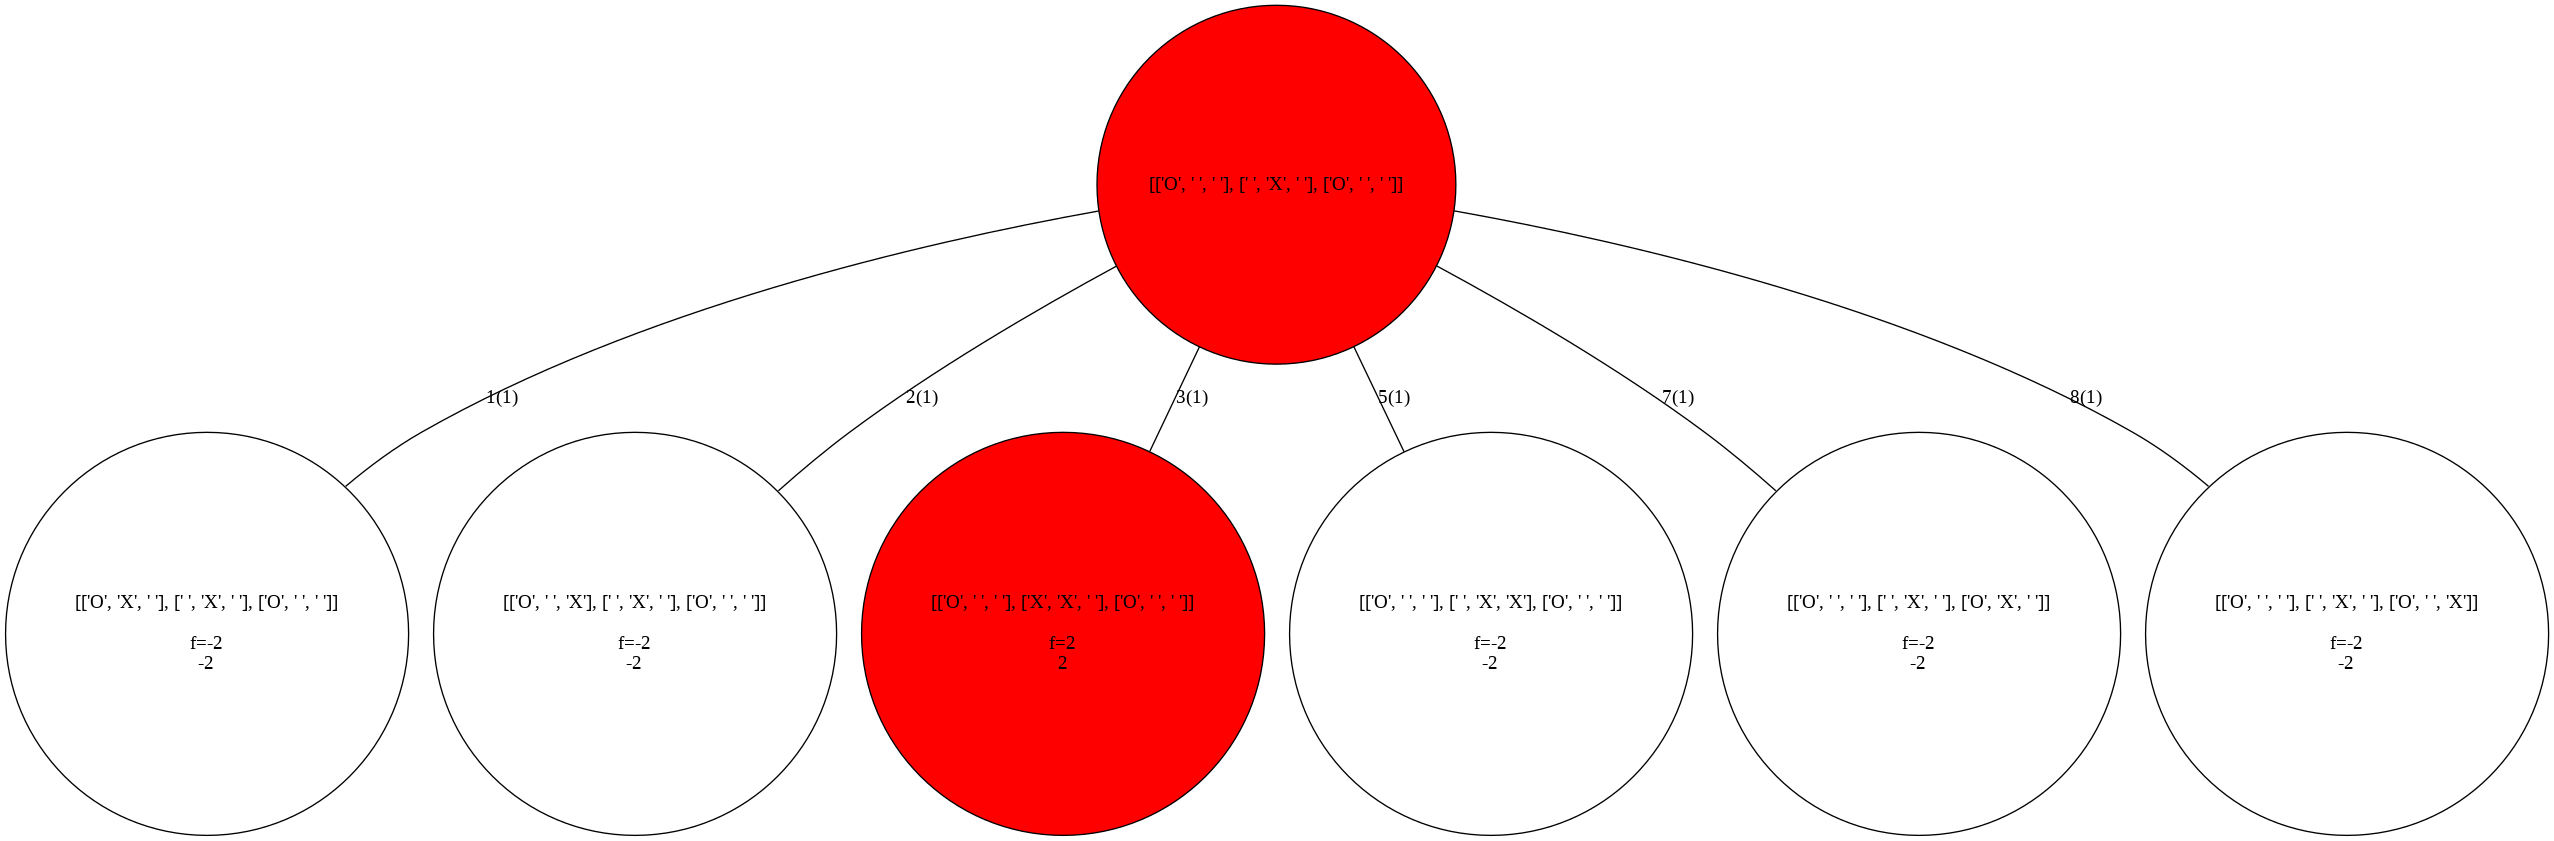

In [13]:
initState=[['O',' ',' '], 
           [' ','X',' '], 
           ['O',' ',' ']]

operators=[(i,j) for i,f in enumerate(initState) for j,c in enumerate(f)]
nodeInit=NodeTicTacToe(True,value="inicio",state=initState, operators= operators)
treeAlfaBeta= Tree(nodeInit,operators)
objective=treeAlfaBeta.AlfaBeta(1)
path=treeAlfaBeta.printPath(objective)
graph=treeAlfaBeta.draw(path.copy())
tree_image = Image(graph.create_png(), width=1000, height=800)
display(tree_image)

In [14]:
0

initState=[[' ',' ',' '], 
           [' ',' ',' '], 
           [' ',' ',' ']]

operators=[(i,j) for i,f in enumerate(initState) for j,c in enumerate(f)]
operators
a = True
while a:
  xin = input('Ingrese y: ')
  yin = input('Ingrese x: ')
  x = int (xin)
  y = int (yin)
  if (x>=0 and x<=2) and (y>=0 and y<=2):
    if initState[x][y] is ' ':
      initState[x][y] = 'O'
      isend = False
      for line in initState:
        if line[0] == 'O' and line[1]=='O' and line[2]=='O':
          isend = True
      if (initState[0][0] == 'O' and initState[1][1] == 'O' and initState[2][2] == 'O') or (initState[0][2] == 'O' and initState[1][1] == 'O' and initState[2][0] == 'O'):
        isend = True
      elif (initState[0][0] == 'O' and initState[1][0] == 'O' and initState[2][0] == 'O') or (initState[0][1] == 'O' and initState[1][1] == 'O' and initState[2][1] == 'O') or (initState[0][2] == 'O' and initState[1][2] == 'O' and initState[2][2] == 'O'):
        isend = True
      if isend:
          a = False
          for i in initState:
            print(i)
          print('Winner')
      elif initState[0][0] != ' ' and initState[1][0] != ' ' and initState[2][0] != ' ' and initState[0][1] != ' ' and initState[0][2] != ' ' and initState[1][1] != ' ' and initState[1][2] != ' ' and initState[2][1] != ' ' and initState[2][2] != ' ' :
        a = False
        for j in initState:
          print(j)
        print('Tie')
      else:
        nodeInit=NodeTicTacToe(True,value="inicio",state=initState, operators= operators)
        treeAlfaBeta= Tree(nodeInit,operators)
        objective=treeAlfaBeta.AlfaBeta(1)
        initState = objective.state        
        for i in initState:
          print(i)
        isend = False
        for line in initState:
          if line[0] == 'X' and line[1]=='X' and line[2]=='X':
            isend = True
          if (initState[0][0] == 'X' and initState[1][1] == 'X' and initState[2][2] == 'X') or (initState[0][2] == 'X' and initState[1][1] == 'X' and initState[2][0] == 'X'):
            isend = True
          elif (initState[0][0] == 'X' and initState[1][0] == 'X' and initState[2][0] == 'X') or (initState[0][1] == 'X' and initState[1][1] == 'X' and initState[2][1] == 'X') or (initState[0][2] == 'X' and initState[1][2] == 'X' and initState[2][2] == 'X'):
            isend = True
        if isend:
          a = False
          print('Loser')
        
    else:
      print('La celda esta ocupada')
  else:
    print('Valor no valido')
  
    

Ingrese y: 2
Ingrese x: 2
['X', ' ', ' ']
[' ', ' ', ' ']
[' ', ' ', 'O']
Ingrese y: 0
Ingrese x: 2
['X', ' ', 'O']
[' ', ' ', 'X']
[' ', ' ', 'O']
Ingrese y: 2
Ingrese x: 0
['X', ' ', 'O']
[' ', 'X', 'X']
['O', ' ', 'O']
Ingrese y: 2
Ingrese x: 1
['X', ' ', 'O']
[' ', 'X', 'X']
['O', 'O', 'O']
Winner
